In [1]:
import os
import sys

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

In [3]:
from collections import defaultdict
from flow_wmd.documents import Document
from flow_wmd.gale_shapeley import Matcher
from flow_wmd.models import LC_RWMD, WMD, WMDManyToMany, WMDPairs
from flow_wmd.utils import *

from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from scipy.spatial.distance import is_valid_dm, cdist
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import cluster

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import umap
import umap.plot

%load_ext autoreload
%autoreload 2

## 1. Prepare IMDB data

### 1.1 Load data and stopwords.

In [4]:
PATH = "../data/"
imdb_data = pd.read_csv(f"{PATH}IMDB_Dataset.csv")
stopword_list=stopwords.words('english')

### 1.2 Remove special formatting and stopwords

In [5]:
tokenizer = ToktokTokenizer()

Remove stopwords before denoising, lemmatizing and removing special characters.

In [6]:
%%time 

imdb_data['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in imdb_data['review']]

CPU times: user 35 s, sys: 281 ms, total: 35.2 s
Wall time: 35.6 s


Denoise, remove special characters, lemmatize.

In [7]:
%%time

imdb_data['review_clean']=imdb_data['review_clean'].apply(denoise_text)
imdb_data['review_clean']=imdb_data['review_clean'].apply(remove_special_characters)
imdb_data['review_clean']=imdb_data['review_clean'].apply(simple_lemmatizer)

CPU times: user 25.9 s, sys: 279 ms, total: 26.2 s
Wall time: 26.4 s


Remove stopwords again, after other preprocessing.

In [8]:
%%time 

imdb_data['review_clean']= [remove_stopwords(r, stopword_list, tokenizer) for r in imdb_data['review_clean']]

CPU times: user 19.4 s, sys: 87.1 ms, total: 19.5 s
Wall time: 19.6 s


Find phrases.

In [9]:
%%time

imdb_data['review_clean']= get_phrases([tokenizer.tokenize(i) for i in imdb_data['review_clean']])

Initializing bigram Phrases.
Initializing trigram Phrases.
Finding bigrams in data.
Finding trigrams in data.
CPU times: user 1min 8s, sys: 1.17 s, total: 1min 9s
Wall time: 1min 10s


Data _before_ preprocessing and phrasing.

In [10]:
imdb_data['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Data _after_ preprocessing and phrasing.

In [11]:
" ".join(imdb_data['review_clean'][0])

'one reviewer_mentioned watching oz episode hooked right exactly_happened first thing struck oz brutality unflinching scene violence set right word go trust show faint_hearted timid show pull_punch regard drug sex_violence hardcore classic use_word called oz nickname given oswald maximum_security state penitentary focus_mainly emerald_city experimental section prison_cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far_away would say main appeal show due_fact go show dare forget pretty picture painted mainstream_audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high_level graphic_violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle_class inmate turned prison bitch due_lack street skill prison experience watching oz m

### 1.3 Separate pos and neg reviews

In [12]:
pos = imdb_data[imdb_data.sentiment == "positive"].reset_index(drop=True)
neg = imdb_data[imdb_data.sentiment == "negative"].reset_index(drop=True)

In [13]:
pos = pos.review_clean.tolist()
neg = neg.review_clean.tolist()

## 2. WMD

### 2.1 Tokenize and "sample" data

In [14]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos[:500]))
neg_tok = list(map(lambda x: tokenize(x, tokenizer), neg[:500]))

In [15]:
pos_sample = [" ".join(doc) for doc in pos_tok]
neg_sample = [" ".join(doc) for doc in neg_tok]

### 2.2 Load pretrained Google News W2V model

In [16]:
finetuned = True

In [17]:
if not finetuned:
    print("Loading GoogleNews Vectors")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)
else:
    print("Loading GoogleNews Vectors finetuned using IMDB review data.")
    %time model = KeyedVectors.load_word2vec_format('../embeddings/imdb_w2v.txt', binary=False)

Loading GoogleNews Vectors finetuned using IMDB review data.
CPU times: user 11 s, sys: 252 ms, total: 11.3 s
Wall time: 11.3 s


In [18]:
model.distance("citizen", "kane")

0.45544904470443726

### 2.3 Load corpus and remove OOV words

In [19]:
%%time

corpus = pos_sample + neg_sample
vectorizer = TfidfVectorizer(use_idf=False, tokenizer=tfidf_tokenize, norm='l1')
vectorizer.fit(corpus)

/Users/mikaelbrunila/Documents/Code/flow-wmd/venv-fwmd/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 773 ms, sys: 7.42 ms, total: 781 ms
Wall time: 784 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7fde53f2fa60>,
                use_idf=False)

In [20]:
%time oov = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 20 ms, sys: 520 µs, total: 20.5 ms
Wall time: 20.4 ms


In [21]:
len(oov)

1440

In [22]:
print(oov[:50])

["'", ',', '[', '_fargo_', '_inspire_', 'abbottwe', 'abedded', 'ableand', 'according_dvd_sleeve', 'achieve_dream', 'acin', 'acquaintaces', 'acroyd', 'actinglack', 'actingperformance', 'actingthis', 'actionfighting', 'actionlevel', 'adherance', 'adjuster', 'adobye', 'adventureoh', 'afflicting', 'afterlives', 'againandagain', 'agendait', 'air_america', 'aired_tv', 'airplane_naked_gun', 'alameo', 'alexakis', 'alfrie', 'aliengiantbugmonsterinvisibleman', 'alienridden', 'alligatorspaul', 'allosaurus', 'allusionshomagesripoffs', 'allwise', 'almostolympian', 'altasianmovies', 'altmanquirky', 'altro', 'alwaysdependable', 'amilee', 'anatolia', 'andrewsblake', 'andrewsedwards', 'angelena', 'animationsciencefiction', 'ankur']


In [23]:
%time pos_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), pos_sample[:500]))
%time neg_sample = list(map(lambda x: remove_oov(x, tokenizer, oov), neg_sample[:500]))

CPU times: user 1.28 s, sys: 5.94 ms, total: 1.28 s
Wall time: 1.29 s
CPU times: user 1.23 s, sys: 6.34 ms, total: 1.24 s
Wall time: 1.24 s


In [24]:
pos_sample[0]

'one reviewer_mentioned watching oz episode hooked right exactly_happened first thing struck oz brutality unflinching scene violence set right word go trust show faint_hearted timid show pull_punch regard drug sex_violence hardcore classic use_word called oz nickname given oswald maximum_security state penitentary focus_mainly emerald_city experimental section prison_cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far_away would say main appeal show due_fact go show dare forget pretty picture painted mainstream_audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high_level graphic_violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle_class inmate turned prison bitch due_lack street skill prison experience watching oz m

In [25]:
corpus = pos_sample + neg_sample

%time vectorizer = TfidfVectorizer(use_idf=True, tokenizer=tfidf_tokenize,norm='l1')
%time vectorizer.fit(corpus)

CPU times: user 22 µs, sys: 1 µs, total: 23 µs
Wall time: 25.3 µs
CPU times: user 246 ms, sys: 5.23 ms, total: 251 ms
Wall time: 256 ms


TfidfVectorizer(norm='l1',
                tokenizer=<function tfidf_tokenize at 0x7fde53f2fa60>)

Bag-of-words vectorizer.

In [26]:
%time
pos_nbow = vectorizer.transform(pos_sample)
neg_nbow = vectorizer.transform(neg_sample)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [27]:
pos_tok = list(map(lambda x: tokenize(x, tokenizer), pos_sample[:500]))
neg_tok =list(map(lambda x: tokenize(x, tokenizer), neg_sample[:500]))

In [28]:
print(pos_tok[0][:20])

['one', 'reviewer_mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly_happened', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scene', 'violence', 'set', 'right', 'word', 'go']


In [29]:
%time oov_ = [word for word in vectorizer.get_feature_names() if word not in model.key_to_index.keys()]

CPU times: user 23.7 ms, sys: 833 µs, total: 24.6 ms
Wall time: 24.3 ms


In [30]:
len(oov_)

0

### 2.4 Get features and embeddings

In [31]:
features = vectorizer.get_feature_names()
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
idx2word = {idx: word for idx, word in enumerate(vectorizer.get_feature_names())}

Get the embedding matrix "E" for all features.

In [32]:
E = model[features]
#E = np.vstack([model.get_vector(word) for word in vectorizer.get_feature_names()])

### 2.5 Cluster

In order to make the results of the WMD model more interpretable, we add the option to inspect the output not only by individual words, but also by *word clusters*. We do this by clustering the input words with two different algorithms
and assigning each word to a cluster.

#### 2.5.1 Kmeans

First, we get the embeddings for the words that are in our feature space.

In [32]:
#X = model[features]

Then we select the number of clusters we want, initialize the Kmeans model and fit it.

In [33]:
%%time

K = range(5,105, 5)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 8.82 µs


In [240]:
%%time

wvec_ssd, wvec_silhouette = kmeans_search(E, K)

For n_clusters = 5 The average silhouette_score is : 0.20111598
For n_clusters = 10 The average silhouette_score is : 0.072588645
For n_clusters = 15 The average silhouette_score is : 0.074699454
For n_clusters = 20 The average silhouette_score is : 0.07060568
For n_clusters = 25 The average silhouette_score is : 0.05947911
For n_clusters = 30 The average silhouette_score is : 0.057747163
For n_clusters = 35 The average silhouette_score is : 0.052976962
For n_clusters = 40 The average silhouette_score is : 0.05577521
For n_clusters = 45 The average silhouette_score is : 0.04736106
For n_clusters = 50 The average silhouette_score is : 0.043115593
For n_clusters = 55 The average silhouette_score is : 0.041144513
For n_clusters = 60 The average silhouette_score is : 0.04126182
For n_clusters = 65 The average silhouette_score is : 0.043678906
For n_clusters = 70 The average silhouette_score is : 0.0334392
For n_clusters = 75 The average silhouette_score is : 0.04034966
For n_clusters = 80 

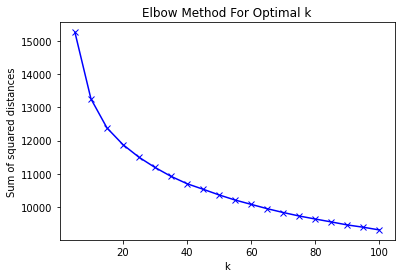

In [241]:
plot_kmeans(K,wvec_ssd,"elbow")

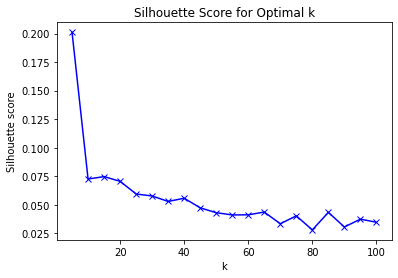

In [242]:
plot_kmeans(K,wvec_silhouette,"silhouette")

Assign labels and centroids to separate variables for later use.

#### 2.5.2 T-SNE + Kmeans

In [34]:
method='barnes_hut'
n_components = 2
verbose = 1

In [35]:
E_tsne = TSNE(n_components=n_components, method=method, verbose=verbose).fit_transform(E)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19970 samples in 0.004s...
[t-SNE] Computed neighbors for 19970 samples in 9.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19970
[t-SNE] Computed conditional probabilities for sample 2000 / 19970
[t-SNE] Computed conditional probabilities for sample 3000 / 19970
[t-SNE] Computed conditional probabilities for sample 4000 / 19970
[t-SNE] Computed conditional probabilities for sample 5000 / 19970
[t-SNE] Computed conditional probabilities for sample 6000 / 19970
[t-SNE] Computed conditional probabilities for sample 7000 / 19970
[t-SNE] Computed conditional probabilities for sample 8000 / 19970
[t-SNE] Computed conditional probabilities for sample 9000 / 19970
[t-SNE] Computed conditional probabilities for sample 10000 / 19970
[t-SNE] Computed conditional probabilities for sample 11000 / 19970
[t-SNE] Computed conditional probabilities for sample 12000 / 19970
[t-SNE] Computed conditional probabilities for sam

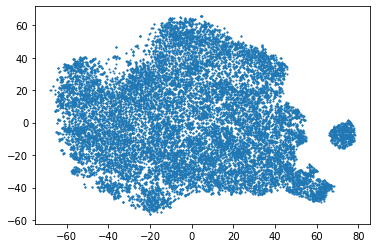

In [37]:
plt.scatter(E_tsne[:, 0], E_tsne[:, 1], s=1);

In [52]:
%%time

tsne_ssd, tsne_silhouette = kmeans_search(E_tsne, K)

For n_clusters = 5 The average silhouette_score is : 0.3746598
For n_clusters = 10 The average silhouette_score is : 0.36901867
For n_clusters = 15 The average silhouette_score is : 0.3820089
For n_clusters = 20 The average silhouette_score is : 0.37787673
For n_clusters = 25 The average silhouette_score is : 0.37580648
For n_clusters = 30 The average silhouette_score is : 0.37369773
For n_clusters = 35 The average silhouette_score is : 0.37200108
For n_clusters = 40 The average silhouette_score is : 0.36375844
For n_clusters = 45 The average silhouette_score is : 0.36583894
For n_clusters = 50 The average silhouette_score is : 0.3656053
For n_clusters = 55 The average silhouette_score is : 0.36320007
For n_clusters = 60 The average silhouette_score is : 0.3498459
For n_clusters = 65 The average silhouette_score is : 0.36189234
For n_clusters = 70 The average silhouette_score is : 0.36026916
For n_clusters = 75 The average silhouette_score is : 0.3510822
For n_clusters = 80 The average

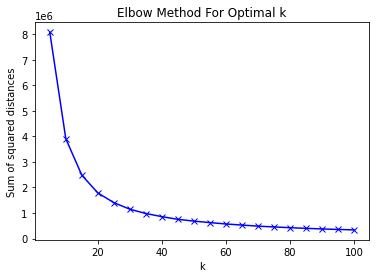

In [53]:
plot_kmeans(K,tsne_ssd,"elbow")

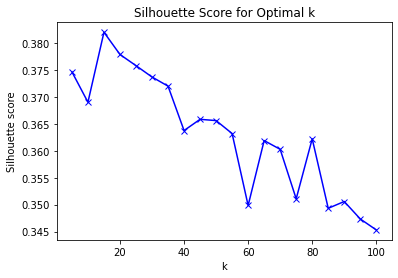

In [54]:
plot_kmeans(K,tsne_silhouette,"silhouette")

#### 2.5.3 PCA + Kmeans

In [46]:
n_components = 0.9
verbose = 1

In [47]:
pca_fit = PCA(n_components = n_components).fit(E)

In [48]:
print(len(pca_fit.explained_variance_ratio_))
print(pca_fit.explained_variance_ratio_)
print(np.sum(pca_fit.explained_variance_ratio_))

31
[0.20904349 0.12344713 0.09292044 0.07319611 0.06892131 0.04888061
 0.03278879 0.02680092 0.02596672 0.02008947 0.01969723 0.01555908
 0.01480959 0.01374452 0.01256809 0.01187242 0.01022555 0.00871704
 0.00792144 0.00776878 0.00637864 0.00631221 0.0062162  0.00572174
 0.0053664  0.00513522 0.00474725 0.00442144 0.00399146 0.00387054
 0.00362636]
0.90072626


In [165]:
E_pca = pca_fit.transform(E)

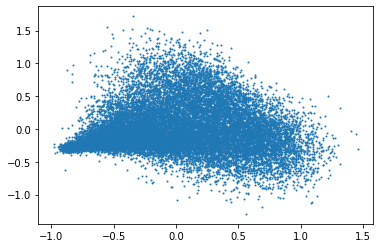

In [50]:
plt.scatter(E_pca[:, 0], E_pca[:, 1], s=1);

In [248]:
%%time

pca_ssd, pca_silhouette = kmeans_search(E_pca, K)

For n_clusters = 5 The average silhouette_score is : 0.21691686
For n_clusters = 10 The average silhouette_score is : 0.09390487
For n_clusters = 15 The average silhouette_score is : 0.09522184
For n_clusters = 20 The average silhouette_score is : 0.08357129
For n_clusters = 25 The average silhouette_score is : 0.08020253
For n_clusters = 30 The average silhouette_score is : 0.08010868
For n_clusters = 35 The average silhouette_score is : 0.07142135
For n_clusters = 40 The average silhouette_score is : 0.075626224
For n_clusters = 45 The average silhouette_score is : 0.065899484
For n_clusters = 50 The average silhouette_score is : 0.062159568
For n_clusters = 55 The average silhouette_score is : 0.06529049
For n_clusters = 60 The average silhouette_score is : 0.06851182
For n_clusters = 65 The average silhouette_score is : 0.06369653
For n_clusters = 70 The average silhouette_score is : 0.048694625
For n_clusters = 75 The average silhouette_score is : 0.060717437
For n_clusters = 80 T

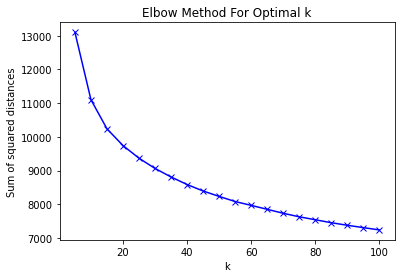

In [249]:
plot_kmeans(K,pca_ssd,"elbow")

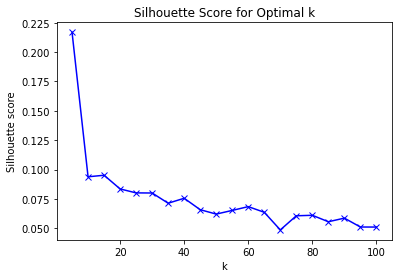

In [250]:
plot_kmeans(K,pca_silhouette,"silhouette")

#### 2.5.4 UMAP + Kmeans

In [55]:
%%time

metric = 'cosine'
dm = cdist(E, E, metric)
np.fill_diagonal(dm, 0)

CPU times: user 2min 13s, sys: 2.39 s, total: 2min 15s
Wall time: 2min 18s


In [56]:
is_valid_dm(dm)

True

In [57]:
mean, std = np.mean(dm), np.std(dm)
print(mean, std)

0.21609533609980103 0.12643356971363268


In [58]:
min_dist=mean - 1*std
n_neighbors = int(0.001*len(E))
n_components=2
print(f"Min distance: {min_dist}")
print(f"N. neighbors: {n_neighbors}")
print(f"N. compontents: {n_components}")

Min distance: 0.08966176638616835
N. neighbors: 19
N. compontents: 2


In [59]:
%%time

E_umap = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
    verbose=verbose
).fit_transform(E)

UMAP(dens_frac=0.0, dens_lambda=0.0, min_dist=0.08966176638616835,
     n_neighbors=19, random_state=42, verbose=1)
Construct fuzzy simplicial set
Fri Jul 23 15:52:46 2021 Finding Nearest Neighbors
Fri Jul 23 15:52:46 2021 Building RP forest with 12 trees
Fri Jul 23 15:52:47 2021 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Fri Jul 23 15:52:59 2021 Finished Nearest Neighbor Search
Fri Jul 23 15:53:01 2021 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jul 23 15:53:15 2021 Finished embedding
CPU times: user 33 s, sys: 723 ms, total: 33.7 s
Wall time: 28.9 s


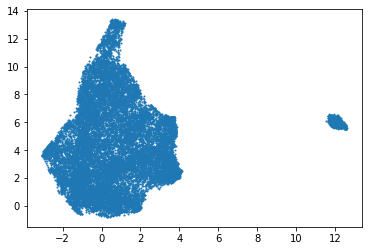

In [60]:
plt.scatter(E_umap[:, 0], E_umap[:, 1], s=1);

In [62]:
%%time

umap_ssd, umap_silhouette = kmeans_search(E_umap, K)

For n_clusters = 5 The average silhouette_score is : 0.4446632
For n_clusters = 10 The average silhouette_score is : 0.4173587
For n_clusters = 15 The average silhouette_score is : 0.39963198
For n_clusters = 20 The average silhouette_score is : 0.39286843
For n_clusters = 25 The average silhouette_score is : 0.38249004
For n_clusters = 30 The average silhouette_score is : 0.3841333
For n_clusters = 35 The average silhouette_score is : 0.3800874
For n_clusters = 40 The average silhouette_score is : 0.38275945
For n_clusters = 45 The average silhouette_score is : 0.37970075
For n_clusters = 50 The average silhouette_score is : 0.37809145
For n_clusters = 55 The average silhouette_score is : 0.378091
For n_clusters = 60 The average silhouette_score is : 0.3772782
For n_clusters = 65 The average silhouette_score is : 0.37710878
For n_clusters = 70 The average silhouette_score is : 0.36051974
For n_clusters = 75 The average silhouette_score is : 0.37386245
For n_clusters = 80 The average s

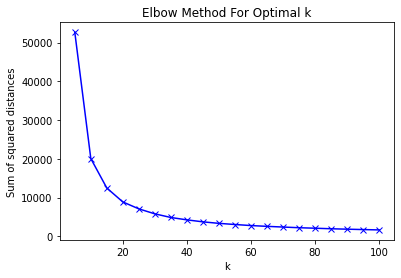

In [63]:
plot_kmeans(K,umap_ssd,"elbow")

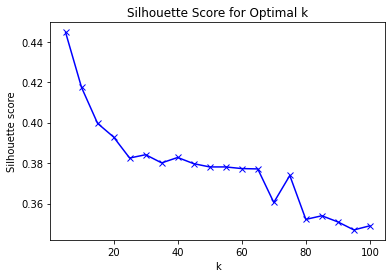

In [64]:
plot_kmeans(K,umap_silhouette,"silhouette")

#### 2.5.5 Choose clustering model

In [100]:
k = 100

In [ ]:
%%time

km_base = cluster.KMeans(n_clusters=k,max_iter=300).fit(E)
labels = km_base.labels_
centroids = km_base.cluster_centers_

km_pca = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_pca)
labels_pca = km_pca.labels_

km_umap = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_umap)
labels_umap=km_umap.labels_

km_tsne = cluster.KMeans(n_clusters=k,max_iter=300).fit(E_tsne)
labels_tsne = km_tsne.labels_

Create an index that maps each word to a cluster.

In [ ]:
word2cluster = {features[idx]: cl for idx, cl in enumerate(labels)}

In [ ]:
print(take(10, word2cluster.items()))

Now, conversely, create an index that maps each cluster to a word.

In [ ]:
cluster2words = defaultdict(list)
for key, value in word2cluster.items():
    cluster2words[value].append(key)

In [ ]:
print(len(cluster2words[0]))
print(cluster2words[0][:100])

In [ ]:
print(len(cluster2words[1]))
print(cluster2words[1][:100])

### 2.6 Initialize documents

Transform all reviews into "documents", each with a set of weights per word in the corpus ("nbow"), the sum of these weights ("weights_sum"), the indeces of the words in the documents ("idxs") and the word vectors corresponding to each word ("vecs").

In [84]:
pos_nbow[0]

<1x19970 sparse matrix of type '<class 'numpy.float64'>'
	with 124 stored elements in Compressed Sparse Row format>

In [242]:
%%time 

pos_docs, neg_docs = [], []

for idx, doc in enumerate(pos_tok):
    pos_docs.append(Document(doc, pos_nbow[idx], word2idx, E, idx))
    
for idx, doc in enumerate(neg_tok):
    neg_docs.append(Document(doc, neg_nbow[idx], word2idx, E, idx))

CPU times: user 435 ms, sys: 378 ms, total: 813 ms
Wall time: 1.21 s


In [243]:
pos_docs[0].nbow

array([[0.00134629, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [244]:
pos_docs[0].weights_sum

0.9999999999999996

In [245]:
pos_docs[0].idxs[:10]

[0, 15363, 4612, 7177, 6154, 13837, 3091, 10771, 16414, 10784]

In [246]:
pos_docs[0].vecs[:1][0][:10]

array([ 0.06953344, -0.05923931, -0.0135353 , -0.04655155, -0.05509005,
       -0.0320261 ,  0.16074686,  0.02574036,  0.01131788,  0.08215761],
      dtype=float32)

### 2.7 Linear-Complexity Relaxed WMD (LC-RWMD)

Run the [Linear-Complexity Relaxed WMD](https://arxiv.org/abs/1711.07227) to get the distances between all positive and all negative reviews.

In [92]:
lc_rwmd = LC_RWMD(pos_docs, neg_docs,pos_nbow,neg_nbow,E)

In [93]:
%time lc_rwmd.get_D('cosine')

CPU times: user 2min 22s, sys: 28 s, total: 2min 50s
Wall time: 45.7 s


In [48]:
#%time lc_rwmd.get_L(1)

In [49]:
#%time lc_rwmd.get_rwmd()

### 2.8 Gale-Shapeley Pairing

Use the [Gale-Shapeley matching algorithm](https://en.wikipedia.org/wiki/Gale%E2%80%93Shapley_algorithm) to find the optimal pairs between positive and negative reviews. This iterates over all the reviews and finds the set of matches that pairs each review with its optimal match given that all positive reviews have to be matched with a negative review and vice versa. The output is a dictionary of key-value pairs, where each pair represents an optimal match.

In [249]:
# Options: 'gale_shapeley','random','full'

pairing = 'gale_shapeley'

In [250]:
%%time

if pairing == 'gale_shapeley':
    print("Running Gale-Shapeley pairing.")
    matcher = Matcher(lc_rwmd.D)
    engaged = matcher.matchmaker()
    matcher.check()
    pairs = [(k, v) for k, v in engaged.items()]
    #pairs = engaged
if pairing == 'random':
    print("Running random pairing.")
    pos_idx = list(range(0,len(pos_docs)))
    neg_idx = list(range(0,len(neg_docs)))
    shuffle(pos_idx)
    shuffle(neg_idx)
    pairs = zip(pos_idx, neg_idx)
if pairing == 'full':
    print("Running full pairing.")
    pos_idx = list(range(0,len(pos_docs)))
    neg_idx = list(range(0,len(neg_docs)))
    pairs = [(i,j) for i in pos_idx for j in neg_idx]
    #pos_docs = [d for d in pos_docs for _ in list(range(0,len(neg_docs)))]
    #neg_docs = [d for d in neg_docs for _ in list(range(0,len(pos_docs)))]

Running Gale-Shapeley pairing.
CPU times: user 2.49 s, sys: 623 ms, total: 3.11 s
Wall time: 3.76 s


Let's look at the output of Gale-Shapeley:

In [251]:
print(pairs[:20])

[(498, 373), (45, 249), (432, 332), (70, 125), (308, 45), (220, 21), (80, 186), (271, 183), (497, 41), (228, 254), (162, 403), (81, 330), (227, 138), (430, 185), (123, 237), (281, 322), (224, 275), (312, 76), (273, 479), (47, 24)]


Let's look at the output of Gale-Shapeley:

In [96]:
example_pairs = [(' '.join(word for word in pos_docs[p[0]].words), 
                  ' '.join(word for word in neg_docs[p[1]].words))
                 for p in take(10, pairs.items())]

In [97]:
example_pairs[9][0]

'one word_describe movie weird recorded movie one day japanese_animation old thought would interesting well movie young_boy travel universe get metal body seek_revenge way meet colorful character must ultimately decide want body strange fan might want check ]'

In [98]:
example_pairs[9][1]

'weak stale tired cliched want basic_instinct miss_opportunity opportunity fresh_perspective new insight insipid trite grotesque without value brevity oh_wait minute_long must seemed lot longer rather clean bus_station toilet toothbrush sit expressing opinion guess mean like ]'

### 2.9 Pairwise WMD with Baseline Kmeans

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm _without_ returning the flow between individual words.

In [254]:
%%time 

wmd_pairs = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word
wmd_pairs.get_distances(thread=False,relax=True))

Calculated distances between approximately 0 documents. 00h00m00s elapsed.
CPU times: user 1min 42s, sys: 10.4 s, total: 1min 52s
Wall time: 59.4 s


The return value is a matrix of distances between the document pairs.

In [255]:
np.sum(wmd_pairs.distances)

122.06975463544016

Calculate the pairwise distances between the documents selected by the Galey-Shapeley algorithm, this time also returning the flow between individual words.

In [239]:
%%time 

wmd_pairs_flow = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word,metric='euclidean')
wmd_pairs_flow.get_distances(return_flow = True, 
                             sum_clusters = True, 
                             w2c = word2cluster, 
                             c2w = cluster2words,
                             thread = False,
                             relax = True)

Calculated distances between 0 documents.
Calculated distances between 100 documents.
Calculated distances between 200 documents.
Calculated distances between 300 documents.
Calculated distances between 400 documents.
CPU times: user 14.9 s, sys: 2.88 s, total: 17.8 s
Wall time: 5.08 s


Now we have three return values.

The first one is again a matrix of distances between the document pairs.

In [240]:
np.max(wmd_pairs_flow.distances)

2.0200801027254065

The second return value is a list of tuples with all the words that contributed the most to the distance from the positive documents to the negative ones. These are _not_ sorted from high to low or vice versa.

In [227]:
take(10, wmd_pairs_flow.wc_X1.items())

[('kline', 0.03108878067091774),
 ('patsy_kelly', 0.005171586020049816),
 ('flipping_channel', 0.03471551293015668),
 ('hurt', 0.08245787190770568),
 ('behind', 0.215589473253471),
 ('eleanor', 0.0017097632183477511),
 ('terminator', 0.004410259473284981),
 ('davis', 0.018084669568702298),
 ('drunk', 0.042374265087251776),
 ('mortimer', 0.007068006154108881)]

The third return value is a list of tuples with all the words that contributed the most to the distance from the negative documents to the positive ones. Again, these are _not_ sorted from high to low or vice versa.

In [228]:
take(10, wmd_pairs_flow.wc_X2.items())

[('flipping_channel', 0.02816522779251392),
 ('hurt', 0.1704751561104262),
 ('behind', 0.12336069354680605),
 ('skinned', 0.005471983548026141),
 ('linebyline', 0.00578429535628372),
 ('got_bored', 0.020140395293595573),
 ('elder', 0.04292937227961441),
 ('terminator', 0.03245286259673233),
 ('drunk', 0.041306849694188866),
 ('bond', 0.01030751948540237)]

In [229]:
take(10, wmd_pairs_flow.cc_X1.items())

[(45, 3.0153690681350653),
 (14, 2.6389818858754324),
 (39, 8.467641214101926),
 (72, 3.1531639987131452),
 (7, 2.8866938928594514),
 (4, 3.741449420844593),
 (51, 5.029056463151532),
 (26, 3.207607010402123),
 (0, 5.824220657541505),
 (68, 6.337103432597152)]

In [230]:
take(10, wmd_pairs_flow.cc_X2.items())

[(45, 3.8134968082920078),
 (14, 2.936093464561497),
 (39, 5.787358839028018),
 (72, 2.514750278904845),
 (7, 2.95861110981576),
 (4, 3.1555027714158568),
 (51, 2.946260772385002),
 (26, 1.5111910969316251),
 (0, 4.797494570409933),
 (68, 3.9964907920334483)]

In [231]:
{k: v for k, v in sorted(wmd_pairs_flow.cc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{76: 37.625082414561334,
 49: 32.86608704583974,
 16: 22.41735563399503,
 15: 15.186784777990972,
 74: 14.715696925192837,
 29: 13.913405607816715,
 83: 13.216958021825382,
 85: 12.321822105591105,
 73: 12.27347662432497,
 84: 12.207713508589562}

In [232]:
wmd_pairs_flow.get_differences()

### 3.1 Intepreting pairwise WMD flows

Now, let's sort the distances of the words that created the most distance from the positive to the negative reviews.

In [233]:
{k: v for k, v in sorted(wmd_pairs_flow.wc_X1_diff.items(), key=lambda item: item[1], reverse=True)[:30]}

{'great': 2.024668687862805,
 'love': 1.7403624518181244,
 'best': 1.6059609663063412,
 'game': 1.5015966541096764,
 'still': 1.3499619297528755,
 'excellent': 1.2317696857622864,
 'performance': 1.0859712711787703,
 'wonderful': 1.0603686054120842,
 'loved': 0.9965510077848866,
 'life': 0.9757527493648293,
 'young': 0.9428675492488711,
 'little': 0.8657328059834035,
 'song': 0.7914757492606663,
 'family': 0.7577614042786635,
 'year': 0.7028603080048946,
 'man': 0.6986470308364732,
 'disney': 0.687060968904775,
 'brilliant': 0.6608790201913272,
 'time': 0.647052542916104,
 'role': 0.6379634619043805,
 'fan': 0.6058479543678611,
 'enjoy': 0.603238506769767,
 'new': 0.5898779141860254,
 'soundtrack': 0.5858728489065048,
 'take': 0.5528725826338342,
 'perfect': 0.5527254145739504,
 'dvd': 0.5499873334288831,
 'well_worth': 0.5469984017822719,
 'beautiful': 0.5446848814167586,
 'entertaining': 0.5435968111979436}

Next, let's see what added most distance when moving from the negative to the positive reviews.

In [234]:
{k: v for k, v in sorted(wmd_pairs_flow.wc_X2_diff.items(), key=lambda item: item[1], reverse=True)[:30]}

{'bad': 4.31365719467759,
 'worst': 2.1804254284134124,
 'stupid': 1.252488856406775,
 'plot': 1.2280525049979656,
 'movie': 1.1712772773902285,
 'even': 1.1524316885320491,
 'boring': 1.1071308396259822,
 'awful': 1.0893321833532568,
 'acting': 1.0274300530596474,
 'terrible': 0.9682353863779681,
 'could': 0.9619606450165578,
 'money': 0.9271164767602857,
 'funny': 0.8614716477979392,
 'ever_seen': 0.8473709282464739,
 'better': 0.8293585094170678,
 'poor': 0.819561296543107,
 'guy': 0.814833241259636,
 'instead': 0.7903185800398173,
 'one_worst': 0.7507889531035976,
 'made': 0.7420553305082178,
 'kid': 0.7416117962714226,
 'horrible': 0.7130632384926621,
 'try': 0.6937886685546133,
 'rating': 0.6937092545511883,
 'ever': 0.6432402139019233,
 'least': 0.6069506928203487,
 'joke': 0.5879329411746743,
 'worse': 0.5836152756539232,
 'got': 0.5817396592404654,
 'hour': 0.5762534128424041}

Finally, let's look at the distances between the two sets by clustering similar words, in order to get a better sense of what kind of "topics" that separate them. Each cluster has a weight that matches the sum of the words belonging to that cluster. We choose *n* top clusters to inspect. To make the clusters interpretable, we also represent each of them by *m* keywords, selected based on the cost they individually add between the two sets.

In [235]:
n_clusters = 10
n_words = 10

In [236]:
c1 = output_clusters(wc=wmd_pairs_flow.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow.cc_X1.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2 = output_clusters(wc=wmd_pairs_flow.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow.cc_X2.items(), 
                     c2w=cluster2words, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

Positive to negative clusters.

In [237]:
c1

,76,49,16,15,74,29,83,85,73,84
0,little (0.87),great (2.02),hope (0.32),often (0.34),take (0.55),found (0.27),home (0.43),excellent (1.23),performance (1.09),production (0.54)
1,real (0.4),still (1.35),want (0.26),although (0.32),keep (0.26),glad (0.24),night (0.32),wonderful (1.06),role (0.64),work (0.35)
2,every (0.35),loved (1.0),right (0.25),yet (0.32),roll (0.17),impressed (0.18),old (0.29),brilliant (0.66),star (0.44),success (0.18)
3,hard (0.3),fan (0.61),wish (0.23),especially (0.29),run (0.16),thought (0.18),live (0.21),perfect (0.55),play (0.43),hollywood (0.14)
4,one (0.19),enjoy (0.6),people (0.22),typical (0.27),notice (0.13),watched (0.17),friend (0.2),amazing (0.51),playing (0.3),box_office (0.09)
5,matter (0.16),well_worth (0.55),know (0.21),well_acted (0.27),break (0.1),seen (0.17),weekend (0.15),incredible (0.47),supporting_cast (0.15),done (0.09)
6,think (0.16),entertaining (0.54),see (0.18),particularly (0.26),place (0.1),laughed_hard (0.12),vacation (0.15),fantastic (0.37),rest_cast (0.14),studio (0.07)
7,part (0.14),always (0.52),feel_sorry (0.11),quite (0.25),hold (0.09),surprised (0.1),christmas (0.12),lovely (0.29),portrayal (0.13),direct (0.07)
8,sure (0.13),favorite (0.45),folk (0.09),also (0.24),behind (0.09),absolutely_loved (0.1),searching (0.1),superb (0.29),actress (0.11),fault (0.06)
9,way (0.12),definitely (0.42),wanting (0.07),bit (0.21),tied (0.08),amazed (0.1),mine (0.09),memorable (0.24),played (0.1),produce (0.06)


Negative to positive clusters.

In [238]:
c2 

,76,16,49,17,27,84,29,74,20,40
0,even (1.15),maybe (0.52),movie (1.17),bad (4.31),boring (1.11),made (0.74),got (0.58),get (0.53),stupid (1.25),hour (0.58)
1,could (0.96),anyone (0.48),better (0.83),worst (2.18),awful (1.09),producer (0.29),came (0.35),start (0.23),guy (0.81),minute (0.56)
2,instead (0.79),going (0.46),recommend (0.4),ever_seen (0.85),terrible (0.97),director (0.29),disappointed (0.28),next (0.23),ok (0.51),bored (0.43)
3,least (0.61),happen (0.35),expect (0.31),one_worst (0.75),poor (0.82),obviously (0.28),hated (0.28),getting (0.23),suck (0.41),whole_thing (0.33)
4,supposed (0.56),would (0.31),overall (0.29),horrible (0.71),script (0.54),making (0.27),sat (0.26),somewhere (0.15),mean (0.36),ended (0.28)
5,really (0.55),believe (0.29),lot (0.25),worse (0.58),dull (0.48),effort (0.27),went (0.24),stop (0.15),guess (0.34),sit (0.28)
6,nothing (0.55),tried (0.28),much_better (0.16),rent (0.56),dialog (0.47),project (0.22),watching (0.22),hand (0.12),sucked (0.32),entire (0.25)
7,enough (0.52),someone (0.26),want_see (0.15),waste_time (0.54),lame (0.39),writer (0.21),must_say (0.21),away (0.11),seriously (0.24),finished (0.24)
8,something (0.45),wanted (0.26),entertained (0.08),waste (0.51),unbelievable (0.38),blame (0.2),looked (0.21),pull (0.1),cool (0.23),wait (0.2)
9,idea (0.42),never (0.22),chick_flick (0.06),please (0.41),weak (0.34),screenplay (0.18),expected (0.17),sign (0.1),oh (0.18),left (0.19)


## 4 Better clusters with UMAP and T-SNE

#### 4.1 UMAP + Kmeans

In [118]:
word2cluster_u = {features[idx]: cl for idx, cl in enumerate(labels_umap)}

In [119]:
print(take(10, word2cluster_u.items()))

[(']', 84), ('^_', 49), ('`', 4), ('aaargh', 3), ('aaliyah', 8), ('aamir_khan', 54), ('aaron', 13), ('aaron_eckhart', 18), ('ab_tak', 93), ('abandon', 92)]


Now, conversely, create an index that maps each cluster to a word.

In [120]:
cluster2words_u = defaultdict(list)
for key, value in word2cluster_u.items():
    cluster2words_u[value].append(key)

In [121]:
%%time 

wmd_pairs_flow_u = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_u.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_u, 
                               c2w = cluster2words_u,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 3s, sys: 15.9 s, total: 2min 19s
Wall time: 1min 13s


In [123]:
wmd_pairs_flow_u.get_differences()

In [125]:
c1_u = output_clusters(wc=wmd_pairs_flow_u.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow_u.cc_X1.items(), 
                     c2w=cluster2words_u, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2_u = output_clusters(wc=wmd_pairs_flow_u.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow_u.cc_X2.items(), 
                     c2w=cluster2words_u, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

In [126]:
c1_u

,38,65,48,50,6,45,78,16,14,68
0,great (2.48),loved (1.27),game (1.77),dvd (0.7),still (1.8),year (0.8),film (0.68),little (1.23),performance (1.36),story (0.7)
1,best (2.03),enjoy (0.72),hard (0.42),show (0.4),disney (0.89),new (0.67),although (0.37),entertaining (0.66),role (0.9),quality (0.3)
2,excellent (1.42),well_worth (0.67),cartoon (0.18),hope (0.39),every (0.34),night (0.43),cinema (0.36),hilarious (0.5),star (0.55),quite (0.3)
3,wonderful (1.3),want (0.42),people (0.16),channel (0.37),compared (0.19),day (0.39),hollywood (0.22),comedy (0.43),play (0.46),edge_seat (0.23)
4,song (0.96),check (0.25),segal (0.15),found (0.34),taste (0.19),old (0.38),though (0.18),plus (0.32),playing (0.39),build (0.23)
5,brilliant (0.83),liked (0.23),meatball (0.14),buy (0.33),much (0.16),lived (0.35),throughout (0.17),fulci (0.3),great_job (0.31),clever (0.23)
6,perfect (0.75),enjoyed (0.21),animated (0.14),glad (0.31),one (0.15),late (0.33),filled (0.17),humor (0.28),hamlet (0.2),bit (0.23)
7,beautiful (0.68),would_recommend (0.19),subtitle (0.14),film_festival (0.27),sf (0.14),memory (0.29),pure (0.14),martial_art (0.26),davy (0.19),romantic_comedy (0.22)
8,soundtrack (0.67),seen (0.17),serial (0.13),first_saw (0.25),eighty (0.14),grew (0.25),part (0.12),enjoyable (0.23),rest_cast (0.18),extremely (0.19)
9,amazing (0.65),thought (0.17),exactly (0.13),video (0.25),perhaps (0.13),last (0.25),dated (0.11),humour (0.21),supporting_cast (0.18),suspenseful (0.13)


In [127]:
c2_u

,65,48,56,6,30,16,63,50,78,77
0,movie (2.33),would (0.5),bad (5.31),even (1.48),worst (2.48),stupid (1.61),better (1.0),came (0.35),director (0.41),supposed (0.74)
1,really (0.94),reason (0.47),plot (1.52),could (1.22),ever_seen (0.95),funny (0.87),least (0.77),fox (0.31),effort (0.34),case (0.52)
2,rating (0.84),going (0.46),boring (1.38),instead (1.03),one_worst (0.88),joke (0.76),nothing (0.76),sat (0.31),seems (0.27),making (0.43)
3,say (0.72),gave (0.42),awful (1.34),made (0.83),ever (0.74),idiotic (0.39),ok (0.63),episode (0.31),numerous (0.27),understand (0.39)
4,rent (0.7),basically (0.42),terrible (1.24),enough (0.72),hour (0.74),unrealistic (0.37),cheap (0.6),finished (0.28),point (0.27),obviously (0.36)
5,maybe (0.61),never (0.4),poor (1.12),idea (0.59),minute (0.72),lot (0.37),anything (0.56),picked (0.27),contain (0.19),project (0.27)
6,anyone (0.61),wrong (0.4),horrible (0.93),either (0.46),worse (0.72),overall (0.32),sequel (0.43),series (0.25),example (0.18),sort (0.26)
7,watching (0.52),happen (0.39),script (0.7),rest (0.45),something (0.68),nudity (0.29),whole_thing (0.42),blockbuster (0.25),almost (0.15),fact (0.26)
8,review (0.52),tried (0.37),dialog (0.63),make_sense (0.45),waste (0.65),serious (0.28),b (0.41),rented (0.21),shocking (0.15),blame (0.25)
9,recommend (0.48),like (0.37),dull (0.6),producer (0.36),waste_time (0.61),disgusting (0.28),expect (0.39),went_see (0.21),columbo (0.14),confused (0.25)


#### 4.1 T-SNE + Kmeans

In [128]:
word2cluster_t = {features[idx]: cl for idx, cl in enumerate(labels_tsne)}

In [129]:
print(take(10, word2cluster_t.items()))

[(']', 65), ('^_', 25), ('`', 45), ('aaargh', 79), ('aaliyah', 39), ('aamir_khan', 56), ('aaron', 84), ('aaron_eckhart', 20), ('ab_tak', 54), ('abandon', 74)]


Now, conversely, create an index that maps each cluster to a word.

In [139]:
cluster2words_t = defaultdict(list)
for key, value in word2cluster_t.items():
    cluster2words_t[value].append(key)

In [141]:
%%time 

wmd_pairs_flow_t = WMDPairs(pos_docs,neg_docs,pairs,E,idx2word)
wmd_pairs_flow_t.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_t, 
                               c2w = cluster2words_t,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 2min 5s, sys: 14.9 s, total: 2min 20s
Wall time: 1min 16s


In [142]:
wmd_pairs_flow_t.get_differences()

In [143]:
c1_t = output_clusters(wc=wmd_pairs_flow_t.wc_X1_diff.items(), 
                     cc=wmd_pairs_flow_t.cc_X1.items(), 
                     c2w=cluster2words_t, 
                     n_clusters=n_clusters, 
                     n_words=n_words)
c2_t = output_clusters(wc=wmd_pairs_flow_t.wc_X2_diff.items(), 
                     cc=wmd_pairs_flow_t.cc_X2.items(), 
                     c2w=cluster2words_t, 
                     n_clusters=n_clusters, 
                     n_words=n_words)

In [144]:
c1_t

,92,67,86,48,99,87,10,31,17,95
0,loved (1.27),great (2.48),disney (0.89),thought (0.17),game (1.77),performance (1.36),dvd (0.7),real (0.65),feeling (0.6),year (0.8)
1,time (0.84),excellent (1.42),film (0.68),people (0.16),hilarious (0.5),role (0.9),hope (0.39),often (0.4),feel (0.54),night (0.43)
2,well_worth (0.67),wonderful (1.3),entertaining (0.66),exactly (0.13),comedy (0.43),star (0.55),channel (0.37),moving (0.35),message (0.43),day (0.39)
3,fan (0.55),song (0.96),definitely (0.54),folk (0.12),scifi (0.43),play (0.46),found (0.34),filmed (0.21),reality (0.34),lived (0.35)
4,wish (0.28),brilliant (0.83),special (0.39),shocked (0.11),show (0.4),playing (0.39),buy (0.33),top (0.17),theme (0.3),memory (0.29)
5,liked (0.23),perfect (0.75),cinema (0.36),happy_ending (0.11),humor (0.28),great_job (0.31),glad (0.31),main (0.15),issue (0.21),future (0.26)
6,enjoyed (0.21),beautiful (0.68),particularly (0.35),wanting (0.09),short (0.24),usual (0.25),film_festival (0.27),character (0.15),society (0.18),grew (0.25)
7,seen (0.17),soundtrack (0.67),classic (0.33),figured (0.08),clever (0.23),rest_cast (0.18),first_saw (0.25),segment (0.13),importance (0.17),last (0.25)
8,buy_copy (0.16),amazing (0.65),work (0.33),running_time (0.08),humour (0.21),supporting_cast (0.18),video (0.25),sequence (0.13),complex (0.16),took (0.22)
9,really_liked (0.16),incredible (0.59),highly_recommend (0.28),cared (0.08),one_liner (0.17),shine (0.17),theater (0.21),edited (0.11),dealing (0.16),weekend (0.21)


In [145]:
c2_t

,28,92,48,89,49,19,31,42,82,86
0,bad (5.31),movie (2.33),hour (0.74),worst (2.48),even (1.48),really (0.94),shot (0.67),could (1.22),made (0.83),better (1.0)
1,stupid (1.61),rating (0.84),minute (0.72),ever_seen (0.95),enough (0.72),maybe (0.61),scene (0.54),instead (1.03),supposed (0.74),original (0.33)
2,plot (1.52),say (0.72),anyone (0.61),one_worst (0.88),idea (0.59),mean (0.42),camera (0.51),least (0.77),making (0.43),overall (0.32)
3,boring (1.38),watching (0.52),bored (0.58),ever (0.74),premise (0.45),guess (0.38),numerous (0.27),nothing (0.76),wrong (0.4),serious (0.28)
4,awful (1.34),review (0.52),end (0.5),rent (0.7),disappointing (0.36),like (0.37),main_character (0.27),anything (0.56),line (0.27),produced (0.14)
5,terrible (1.24),reason (0.47),depressing (0.49),something (0.68),producer (0.36),someone (0.35),echo (0.19),either (0.46),meant (0.17),standard (0.08)
6,poor (1.12),disappointed (0.34),actually (0.47),waste (0.65),unfortunately (0.35),seriously (0.32),example (0.18),gave (0.42),looking (0.17),bollywood (0.08)
7,horrible (0.93),comment (0.34),going (0.46),waste_time (0.61),stereotype (0.29),anymore (0.26),relentlessly (0.17),laugh (0.34),ruin (0.15),worked (0.07)
8,worse (0.72),saying (0.33),make_sense (0.45),ever_made (0.56),seems (0.27),hate (0.24),clip (0.16),cool (0.32),appeal (0.13),equally (0.07)
9,dialog (0.63),hated (0.32),seemed (0.45),recommend (0.48),project (0.27),hell (0.24),particular (0.16),seagal (0.29),describe (0.12),dubbed (0.07)


## 5 Reduced Dimension Inputs

### 5.1 UMAP

In [ ]:
### TODO: lcwmd with UMAP

In [170]:
%%time 

wmd_pairs_flow_uvecs = WMDPairs(pos_docs,neg_docs,pairs,E_umap,idx2word)
wmd_pairs_flow_uvecs.get_distances(return_flow = True, 
                               sum_clusters = True, 
                               w2c = word2cluster_u, 
                               c2w = cluster2words_u,
                               thread = True)

Calculated distances between approximately 0 documents.
Calculated distances between approximately 100 documents.
Calculated distances between approximately 200 documents.
Calculated distances between approximately 300 documents.
Calculated distances between approximately 400 documents.
CPU times: user 1min 34s, sys: 4.71 s, total: 1min 39s
Wall time: 1min 30s


### 5.2 T-SNE

## 6 Statistical Models

In [234]:
import statsmodels.api as sm

In [317]:
np.max(wmd_pairs_flow.X1_feat)

0.39088

In [276]:
feats = np.copy(wmd_pairs_flow.X1_feat)

In [277]:
feats[feats>0] = 1
feats

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [258]:
np.sum(feats[0,])

39.0

In [279]:
ols = sm.OLS(np.sum(wmd_pairs_flow.X1_feat, axis=1), feats)
res = ols.fit()

In [289]:
params = list(np.round(res.params, 3))

In [309]:
params.index(sorted(params)[-97])

15

In [311]:
params[97]

0.003

In [318]:
print(cluster2words[97])

['addressed', 'allowed', 'apparent', 'avoids', 'breakdown', 'carefully', 'central', 'central_character', 'change', 'changing', 'choosing', 'chosen', 'claustrophobia', 'clear', 'close', 'closest', 'coincidence', 'comedy_tragedy', 'common', 'complicated', 'concentrate', 'concerned', 'concerning', 'conflict', 'connect', 'connected', 'connecting', 'connection', 'consequently', 'construct', 'contempt', 'continuing', 'conviction', 'dealt', 'despicable', 'despite_fact', 'detached', 'develop', 'developed', 'developing', 'development', 'develops', 'device', 'dignity', 'disparate', 'dominate', 'dramatically', 'drawn', 'eliminated', 'encountered', 'establish', 'established', 'establishing', 'event', 'event_unfold', 'evolve', 'evolves', 'explicitly', 'explored', 'fall_apart', 'feel_sympathy', 'fictional', 'focus', 'focused', 'focusing', 'follow', 'following', 'form', 'forward', 'foundation', 'framework', 'gap', 'general', 'glimpse', 'gradual', 'hint', 'hinted', 'hopeless', 'identified', 'ignoring'

## Appendix: Many-to-many WMD

This was a first attempt to do the flows from words between many documents, without first filtering using Gale-Shapeley. However, this proved too inefficient. As you can see looking at the CPU times, it is very slow even with extremely small samples and the time complexity is quadratic (or worse?), meaning it rapidly gets even worse as the sample size increases.

In [155]:
%time m2m_distances = WMDManyToMany(pos_docs[:20], neg_docs[:20],E,idx2word).get_distances(return_flow = False)

CPU times: user 1min 48s, sys: 12.7 s, total: 2min 1s
Wall time: 50 s


In [156]:
%time m2m_distances_flow, wc_X1, wc_X2 = WMDManyToMany(pos_docs[:20],neg_docs[:20],E,idx2word).get_distances(return_flow = True)

CPU times: user 1min 52s, sys: 13.5 s, total: 2min 5s
Wall time: 51.4 s


In [157]:
{k: v for k, v in sorted(wc_X1.items(), key=lambda item: item[1], reverse=True)[:10]}

{'karen': 8.69223,
 'wrenching': 8.31882,
 'carpenter': 7.468960000000001,
 'laughter': 7.467879999999999,
 'liked': 6.864090000000003,
 'mom': 6.791519999999999,
 'gut': 6.759419999999999,
 'love': 6.551409999999997,
 'camp': 6.533080000000001,
 'hr': 6.1393699999999995}

In [158]:
{k: v for k, v in sorted(wc_X2.items(), key=lambda item: item[1], reverse=True)[:10]}

{'hopper': 8.372459999999998,
 'jake': 7.63837,
 'movie': 7.267059999999995,
 'film': 6.936379999999998,
 'shakespeare': 5.99276,
 'oddness': 5.53033,
 'terrible': 4.943440000000001,
 'parent': 4.751790000000001,
 'actor': 4.672620000000001,
 'bad': 4.430020000000002}